In [3]:
# Cell 1: pick one intermediates file + load it
from pathlib import Path
import numpy as np

# Point this to one run
run_dir = Path("./output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"

# Pick a specific layer+seed file (edit as needed)
npz_path = inter_dir / "X_0_seed0.npz"
z = np.load(npz_path)

print("Keys:", z.files)
print("n_samples (test):", z["y_score"].shape[0])
print("n_pairs:", z["y_score"].shape[1])


Keys: ['idx_test', 'triplet_count_per_sample', 'n_implied_absent_pairs_per_sample', 'y_present', 'y_implied_absent', 'y_non_implied_absent', 'y_score', 'y_pred', 'n_total_absent_pairs_per_sample', 'implied_absent_density_per_sample', 'sample_id', 'pair_colors', 'pair_shapes']
n_samples (test): 740
n_pairs: 100


In [4]:
# Cell 2: select one sample from the test set (by index within this npz)
i = 0  # change this to inspect different samples

triplet = int(z["triplet_count_per_sample"][i])
sample_id = int(z["sample_id"][i]) if "sample_id" in z else None

n_implied = int(z["n_implied_absent_pairs_per_sample"][i])
n_total_absent = int(z["n_total_absent_pairs_per_sample"][i]) if "n_total_absent_pairs_per_sample" in z else None

print("sample_idx_in_npz:", i)
print("sample_id:", sample_id)
print("triplet_count:", triplet)
print("n_implied_absent_pairs:", n_implied)
print("n_total_absent_pairs:", n_total_absent)


sample_idx_in_npz: 0
sample_id: 1582
triplet_count: 16
n_implied_absent_pairs: 9
n_total_absent_pairs: 93


In [5]:
# Cell 3: build a table of all 100 pairs (color,shape) with labels and predictions
pair_colors = z["pair_colors"] if "pair_colors" in z else None
pair_shapes = z["pair_shapes"] if "pair_shapes" in z else None

y_present = z["y_present"][i].astype(int)                 # 1 if present in scene
y_implied = z["y_implied_absent"][i].astype(int)          # 1 if implied-absent
y_non_impl = z["y_non_implied_absent"][i].astype(int)     # 1 if absent and not implied
y_score = z["y_score"][i].astype(float)                   # probability
y_pred = z["y_pred"][i].astype(int)                       # thresholded prediction (>= threshold)

rows = []
for j in range(len(y_score)):
    color = str(pair_colors[j]) if pair_colors is not None else str(j)
    shape = str(pair_shapes[j]) if pair_shapes is not None else ""
    rows.append((j, color, shape, y_present[j], y_implied[j], y_non_impl[j], y_score[j], y_pred[j]))

# Sort by predicted score descending so you see the top "hallucinated" pairs first
rows_sorted = sorted(rows, key=lambda r: r[6], reverse=True)

# Pretty-print first 25
# Header
print(
    f"{'j':<4} "
    f"{'color':<12} "
    f"{'shape':<12} "
    f"{'present':<8} "
    f"{'implied_absent':<16} "
    f"{'non_implied_absent':<20} "
    f"{'score':<8} "
    f"{'pred':<6}"
)

# Rows
for r in rows_sorted[:25]:
    print(
        f"{r[0]:<4} "
        f"{str(r[1]):<12} "
        f"{str(r[2]):<12} "
        f"{str(r[3]):<8} "
        f"{str(r[4]):<16} "
        f"{str(r[5]):<20} "
        f"{r[6]:<8.3f} "
        f"{str(r[7]):<6}"
    )



j    color        shape        present  implied_absent   non_implied_absent   score    pred  
67   green        star         1        0                0                    0.999    1     
47   gold         star         1        0                0                    0.996    1     
22   cyan         circle       1        0                0                    0.980    1     
90   saddlebrown  X-shape      1        0                0                    0.866    1     
45   gold         right-arrow  1        0                0                    0.826    1     
27   cyan         star         0        1                0                    0.751    1     
95   saddlebrown  right-arrow  1        0                0                    0.736    1     
60   green        X-shape      1        0                0                    0.627    1     
97   saddlebrown  star         0        1                0                    0.557    1     
40   gold         X-shape      0        1                0  

In [6]:
# Cell 4: show ONLY implied-absent pairs for this sample (these define the FPR for this sample)
implied_idx = np.where(z["y_implied_absent"][i].astype(bool))[0]

print("num implied-absent pairs:", implied_idx.size)
print("j\tcolor\tshape\tscore\tpred")
for j in implied_idx[np.argsort(y_score[implied_idx])[::-1]][:25]:
    color = str(pair_colors[j]) if pair_colors is not None else str(j)
    shape = str(pair_shapes[j]) if pair_shapes is not None else ""
    print(f"{j}\t{color}\t{shape}\t{y_score[j]:.3f}\t{y_pred[j]}")


num implied-absent pairs: 9
j	color	shape	score	pred
27	cyan	star	0.751	1
97	saddlebrown	star	0.557	1
40	gold	X-shape	0.463	0
65	green	right-arrow	0.319	0
42	gold	circle	0.208	0
25	cyan	right-arrow	0.206	0
62	green	circle	0.097	0
20	cyan	X-shape	0.025	0
92	saddlebrown	circle	0.012	0


In [7]:
# Cell 5: compute this sample's implied-absent FPR (per-sample)
# This is exactly: mean(pred) over implied-absent pairs for this sample.
implied_mask = z["y_implied_absent"][i].astype(bool)
if implied_mask.any():
    fpr_sample = float(z["y_pred"][i, implied_mask].mean())
else:
    fpr_sample = np.nan

print("per-sample implied-absent FPR:", fpr_sample)


per-sample implied-absent FPR: 0.2222222222222222


In [8]:
# Cell 6: show how aggregation by triplet works (per-sample, unweighted across scenes)
triplet_all = z["triplet_count_per_sample"].astype(int)
implied_all = z["y_implied_absent"].astype(bool)
y_pred_all = z["y_pred"].astype(bool)

# per-sample FPR vector
fpr_s = np.full(triplet_all.shape[0], np.nan, dtype=float)
for ii in range(len(triplet_all)):
    m = implied_all[ii]
    if m.any():
        fpr_s[ii] = y_pred_all[ii, m].mean()

# pick a triplet bin to inspect, and compute the aggregated value
t = triplet  # or set t=15 etc.
mask_t = triplet_all == t
vals = fpr_s[mask_t]
vals = vals[np.isfinite(vals)]

print("triplet bin:", t)
print("#samples in this npz with that triplet:", int(mask_t.sum()))
print("#valid samples (had >=1 implied-absent pair):", int(np.isfinite(fpr_s[mask_t]).sum()))
print("aggregated per-sample FPR (mean over samples):", float(vals.mean()) if len(vals) else np.nan)
print("min/median/max:", (float(np.min(vals)), float(np.median(vals)), float(np.max(vals))) if len(vals) else None)


triplet bin: 16
#samples in this npz with that triplet: 20
#valid samples (had >=1 implied-absent pair): 20
aggregated per-sample FPR (mean over samples): 0.06892126148705097
min/median/max: (0.0, 0.023809523809523808, 0.5)


In [9]:
# Cell 7: list present pairs in this scene (from y_present)
present_idx = np.where(z["y_present"][i].astype(bool))[0]
print("num present pairs:", present_idx.size)
print("j\tcolor\tshape\tscore\tpred")
for j in present_idx[np.argsort(y_score[present_idx])[::-1]][:25]:
    color = str(pair_colors[j]) if pair_colors is not None else str(j)
    shape = str(pair_shapes[j]) if pair_shapes is not None else ""
    print(f"{j}\t{color}\t{shape}\t{y_score[j]:.3f}\t{y_pred[j]}")


num present pairs: 7
j	color	shape	score	pred
67	green	star	0.999	1
47	gold	star	0.996	1
22	cyan	circle	0.980	1
90	saddlebrown	X-shape	0.866	1
45	gold	right-arrow	0.826	1
95	saddlebrown	right-arrow	0.736	1
60	green	X-shape	0.627	1


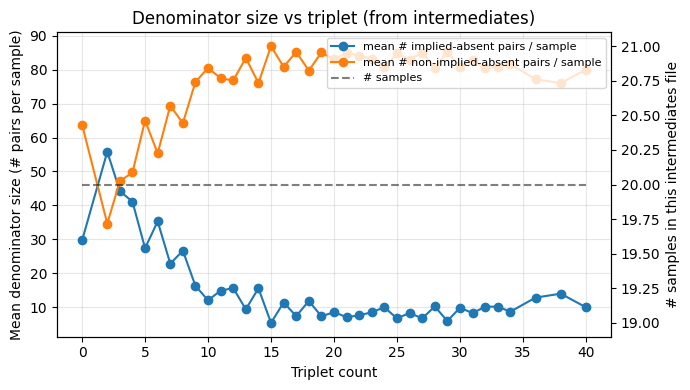

In [10]:
# Cell: sanity check denominator size vs triplet (from one intermediates npz)
import numpy as np
import matplotlib.pyplot as plt

# assumes you already did: z = np.load(npz_path)

triplet = z["triplet_count_per_sample"].astype(int)
mask_implied = z["y_implied_absent"].astype(bool)
mask_non_implied = z["y_non_implied_absent"].astype(bool)

# per-sample denominator sizes (# pairs in each absent set)
n_implied = mask_implied.sum(axis=1)
n_non_implied = mask_non_implied.sum(axis=1)

# group means by triplet
ts = np.unique(triplet)
mean_n_implied_by_t = np.array([n_implied[triplet == t].mean() for t in ts])
mean_n_non_implied_by_t = np.array([n_non_implied[triplet == t].mean() for t in ts])
count_samples_by_t = np.array([(triplet == t).sum() for t in ts])

fig, ax1 = plt.subplots(figsize=(7, 4))

ax1.plot(ts, mean_n_implied_by_t, "o-", label="mean # implied-absent pairs / sample")
ax1.plot(ts, mean_n_non_implied_by_t, "o-", label="mean # non-implied-absent pairs / sample")
ax1.set_xlabel("Triplet count")
ax1.set_ylabel("Mean denominator size (# pairs per sample)")
ax1.grid(alpha=0.3)

# optional: also show how many test samples exist per triplet in this npz
ax2 = ax1.twinx()
ax2.plot(ts, count_samples_by_t, "k--", alpha=0.5, label="# samples")
ax2.set_ylabel("# samples in this intermediates file")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=8)

plt.title("Denominator size vs triplet (from intermediates)")
plt.tight_layout()
plt.show()


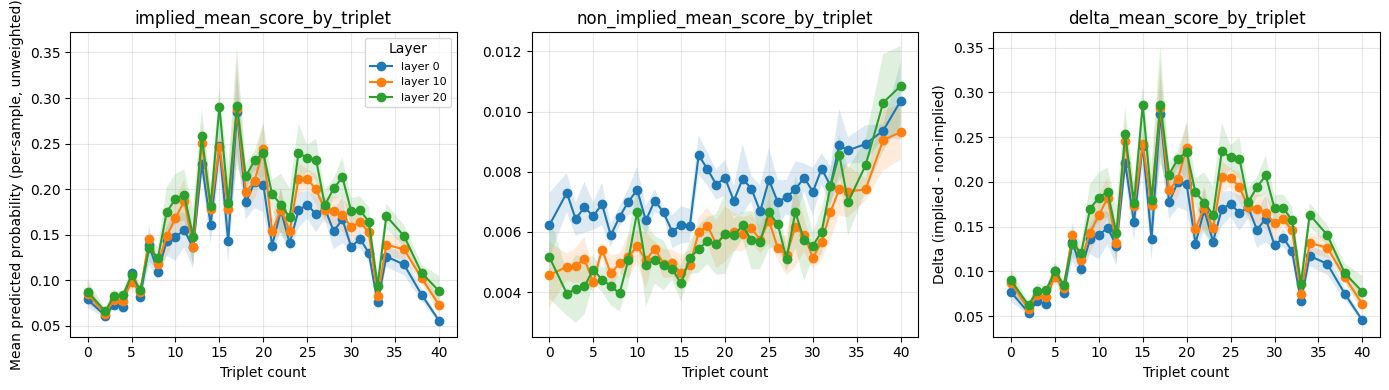

In [12]:
# Cell: plot per-sample mean score metrics vs triplet (from intermediates/*.npz)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

run_dir = Path("./output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"
files = sorted(inter_dir.glob("X_*_seed*.npz"))

def per_sample_mean_scores_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_score = z["y_score"].astype(float)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    # per-sample means
    m_implied = np.full(triplet.shape[0], np.nan, dtype=float)
    m_non = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        mi = implied[i]
        mn = non_implied[i]
        if mi.any():
            m_implied[i] = y_score[i, mi].mean()
        if mn.any():
            m_non[i] = y_score[i, mn].mean()

    delta = m_implied - m_non

    out = {}
    for t in np.unique(triplet):
        mt = triplet == t
        def _mean(x):
            x = x[mt]
            x = x[np.isfinite(x)]
            return float(x.mean()) if len(x) else np.nan
        out[int(t)] = (_mean(m_implied), _mean(m_non), _mean(delta))
    return out

# layer -> list of per-seed dicts (t -> (implied, non, delta))
by_layer = {}
for f in files:
    m = re.match(r"(X_\d+)_seed(\d+)\.npz$", f.name)
    if not m:
        continue
    layer = int(m.group(1).split("_")[1])
    by_layer.setdefault(layer, []).append(per_sample_mean_scores_by_triplet(f))

def aggregate_over_seeds(dicts):
    # returns xs, mean, std for implied/non/delta separately
    all_t = sorted({t for d in dicts for t in d.keys()})
    mats = {"implied": [], "non": [], "delta": []}
    for d in dicts:
        mats["implied"].append([d.get(t, (np.nan, np.nan, np.nan))[0] for t in all_t])
        mats["non"].append([d.get(t, (np.nan, np.nan, np.nan))[1] for t in all_t])
        mats["delta"].append([d.get(t, (np.nan, np.nan, np.nan))[2] for t in all_t])
    out = {}
    for k, mat in mats.items():
        mat = np.array(mat, dtype=float)
        out[k] = (np.array(all_t), np.nanmean(mat, axis=0), np.nanstd(mat, axis=0))
    return out

# Plot implied, non-implied, delta in 3 panels
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
titles = {
    "implied": "implied_mean_score_by_triplet",
    "non": "non_implied_mean_score_by_triplet",
    "delta": "delta_mean_score_by_triplet",
}

for layer in sorted(by_layer):
    agg = aggregate_over_seeds(by_layer[layer])
    for ax, key in zip(axes, ["implied", "non", "delta"]):
        xs, mean, std = agg[key]
        ax.plot(xs, mean, marker="o", label=f"layer {layer}")
        ax.fill_between(xs, mean - std, mean + std, alpha=0.15)

for ax, key in zip(axes, ["implied", "non", "delta"]):
    ax.set_title(titles[key])
    ax.set_xlabel("Triplet count")
    ax.grid(alpha=0.3)
axes[0].set_ylabel("Mean predicted probability (per-sample, unweighted)")
axes[2].set_ylabel("Delta (implied - non-implied)")

axes[0].legend(title="Layer", fontsize=8)
plt.tight_layout()
plt.show()


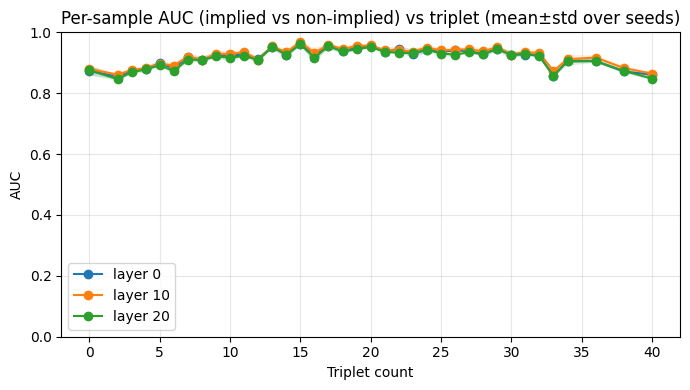

In [14]:
# Cell: per-sample AUC(implied vs non-implied) then average per triplet (mean±std over seeds)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score

run_dir = Path("./output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"
files = sorted(inter_dir.glob("X_*_seed*.npz"))

def per_sample_auc_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_score = z["y_score"].astype(float)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    # compute per-sample AUC
    auc_s = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        mi = implied[i]
        mn = non_implied[i]
        if not mi.any() or not mn.any():
            continue
        s_implied = y_score[i, mi]
        s_non = y_score[i, mn]
        y = np.concatenate([np.ones(len(s_implied), dtype=int), np.zeros(len(s_non), dtype=int)])
        s = np.concatenate([s_implied, s_non])
        # AUC can fail if all scores are identical; catch and leave nan
        try:
            auc_s[i] = roc_auc_score(y, s)
        except ValueError:
            auc_s[i] = np.nan

    # average per triplet
    out = {}
    for t in np.unique(triplet):
        mt = triplet == t
        vals = auc_s[mt]
        vals = vals[np.isfinite(vals)]
        out[int(t)] = float(vals.mean()) if len(vals) else np.nan
    return out

# collect per seed per layer
by_layer = {}
for f in files:
    m = re.match(r"(X_\d+)_seed(\d+)\.npz$", f.name)
    if not m:
        continue
    layer = int(m.group(1).split("_")[1])
    by_layer.setdefault(layer, []).append(per_sample_auc_by_triplet(f))

def aggregate_over_seeds(dicts):
    all_t = sorted({t for d in dicts for t in d.keys()})
    mat = []
    for d in dicts:
        mat.append([d.get(t, np.nan) for t in all_t])
    mat = np.array(mat, dtype=float)
    return np.array(all_t), np.nanmean(mat, axis=0), np.nanstd(mat, axis=0)

plt.figure(figsize=(7,4))
for layer in sorted(by_layer):
    xs, mean, std = aggregate_over_seeds(by_layer[layer])
    plt.plot(xs, mean, marker="o", label=f"layer {layer}")
    plt.fill_between(xs, mean-std, mean+std, alpha=0.15)

plt.title("Per-sample AUC (implied vs non-implied) vs triplet (mean±std over seeds)")
plt.xlabel("Triplet count")
plt.ylabel("AUC")
plt.ylim(0.0, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

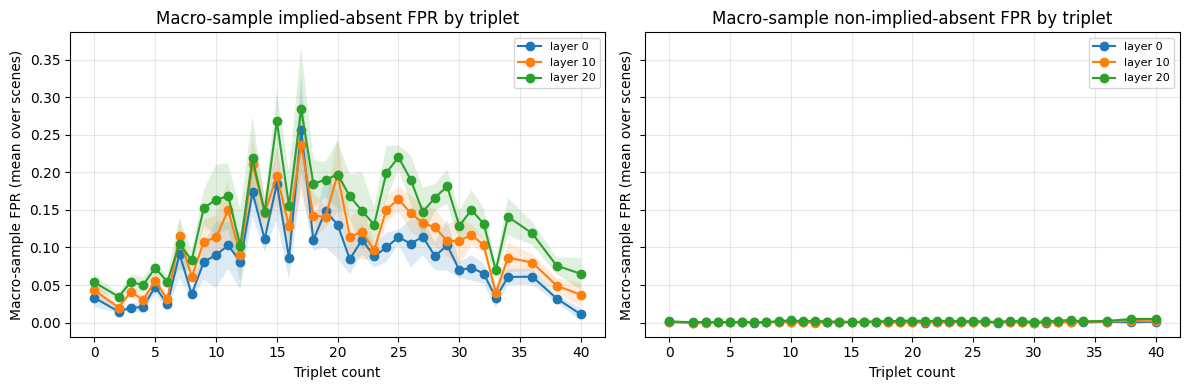

In [16]:
# Cell: macro-sample FPR by triplet (implied + non-implied), mean±std over seeds
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

run_dir = Path("./output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"
files = sorted(inter_dir.glob("X_*_seed*.npz"))

def macro_fpr_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_pred = z["y_pred"].astype(bool)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    # per-sample FPRs (macro over samples later)
    fpr_impl_s = np.full(triplet.shape[0], np.nan, dtype=float)
    fpr_non_s = np.full(triplet.shape[0], np.nan, dtype=float)

    for i in range(len(triplet)):
        mi = implied[i]
        mn = non_implied[i]
        if mi.any():
            fpr_impl_s[i] = y_pred[i, mi].mean()
        if mn.any():
            fpr_non_s[i] = y_pred[i, mn].mean()

    out_impl, out_non = {}, {}
    for t in np.unique(triplet):
        mt = triplet == t

        vi = fpr_impl_s[mt]
        vi = vi[np.isfinite(vi)]
        out_impl[int(t)] = float(vi.mean()) if len(vi) else np.nan

        vn = fpr_non_s[mt]
        vn = vn[np.isfinite(vn)]
        out_non[int(t)] = float(vn.mean()) if len(vn) else np.nan

    return out_impl, out_non

# collect per layer: list of per-seed dicts
by_layer = {}
for f in files:
    m = re.match(r"(X_\d+)_seed(\d+)\.npz$", f.name)
    if not m:
        continue
    layer = int(m.group(1).split("_")[1])
    d_impl, d_non = macro_fpr_by_triplet(f)
    by_layer.setdefault(layer, {"impl": [], "non": []})
    by_layer[layer]["impl"].append(d_impl)
    by_layer[layer]["non"].append(d_non)

def agg(dicts):
    all_t = sorted({t for d in dicts for t in d.keys()})
    mat = np.array([[d.get(t, np.nan) for t in all_t] for d in dicts], dtype=float)
    return np.array(all_t), np.nanmean(mat, axis=0), np.nanstd(mat, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for layer in sorted(by_layer):
    xs, mean, std = agg(by_layer[layer]["impl"])
    axes[0].plot(xs, mean, marker="o", label=f"layer {layer}")
    axes[0].fill_between(xs, mean-std, mean+std, alpha=0.15)

    xs, mean, std = agg(by_layer[layer]["non"])
    axes[1].plot(xs, mean, marker="o", label=f"layer {layer}")
    axes[1].fill_between(xs, mean-std, mean+std, alpha=0.15)

axes[0].set_title("Macro-sample implied-absent FPR by triplet")
axes[1].set_title("Macro-sample non-implied-absent FPR by triplet")
for ax in axes:
    ax.set_xlabel("Triplet count")
    ax.set_ylabel("Macro-sample FPR (mean over scenes)")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()